# Learning from linear data (plus noise)

Welcome to this notebook.

I'm Paulo Abelha and this ntoebook is available at my GitHub http://ww.github.com/pauloabelha/notebooks

I made this as part of my own studies in Machine Learning.

The idea is start simple, but principled and work our way up the abstractions.

Therefore we deal with the "hello world" of Machine Learning: Linear regression

All code in here is of my own authorship.

Main Resources:
- Wikipedia
- David Mackay's bible was a valuable resource: http://www.inference.org.uk/mackay/itila/book.html
- This great paper: MacKay, David JC. "Bayesian interpolation." Neural computation 4.3 (1992): 415-447.
- Another great book: http://www.gaussianprocess.org/gpml/
- Yet another great book: http://www.deeplearningbook.org/

In this notebook we compare four different Machine Learning approaches for fitting a function to noisy linear data
- Linear Regression
- Bayesian Linear Regression
- Neural Networks
- Gaussian Processes


p.s.: One interesting thing would be to implement our own Gaussian distribution sampler:

    http://www.alanzucconi.com/2015/09/16/how-to-sample-from-a-gaussian-distribution/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.patches import Ellipse

# for reproducibility
random_seed_ix = 1
np.random.seed(random_seed_ix)
# number of data points
n_pts = 100
n_dims = 1
# noise (variance of Gaussian distribution for noise)
# sample the noise uniformly at random in [0, 1) and divide by 10
sigma_v_sq = np.random.rand(n_dims,1)/10.0
# sample a weight uniformly at random in [0, 1)
w_1 = np.random.rand(n_dims,1)
# sample a bias uniformly at random in [0, 1)
b = np.random.rand()

**1.1 Helper Functions**

In [2]:
# plot a cooolwarm surface given an m x n matrix Z with values
def my_plot_3Dsurf(range_x,range_y,Z,label_x = 'x',label_y = 'y', viewpoint = 111, fontsize_x = 18, fontsize_y = 18):
    x = np.linspace(range_x[0], range_x[1], Z.shape[0])
    y = np.linspace(range_y[0], range_y[1], Z.shape[1])
    xv, yv = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(viewpoint, projection='3d')
    ax.plot_surface(xv, yv, Z, cmap=cm.coolwarm)
    plt.xlabel(label_x, fontsize=fontsize_x)
    plt.ylabel(label_y, fontsize=fontsize_y)
    plt.show()

In [3]:
# plot a heatmap given an m x n matrix Z with values
def plot_heatmap(Z, cmap = 'cool', extent = [0,1,0,1]):
    #plt.imshow(np.reshape(Z, (Z.shape[0],-1)), extent = extent, origin='higher')
    plt.imshow(np.reshape(Z, (Z.shape[0],-1)), cmap, interpolation='nearest', extent = extent)
    plt.show()

In [77]:
# This function plots a Gaussian with contours representing multiples of standard deviation
# Resources:
#     https://en.wikipedia.org/wiki/Multivariate_normal_distribution
#     http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
def plot_bivariate_gaussian(mean, covar_mtx, N, colour = 'k', plot_fig = True, ax_lims = -1):
    assert(mean.shape == (2, 1))
    assert(covar_mtx.shape == (2, 2))
    assert(N > 0)
    # perform Eigen decomposition to get rotation of Gaussian
    w, U = np.linalg.eig(covar_likelihood)  
    # get index of largest eigenvalue
    max_eig_value_ix = np.argmax(w)
    # get the x and y value of the eigenvector corresponding to largest eigenvalue
    v1x = U[0,max_eig_value_ix]
    v1y = U[1,max_eig_value_ix]
    # get alpha, the angle of rotation for the Gaussian
    alpha = np.arctan(v1y/v1x)
    # get figure
    fig = plt.figure(0)
    # create axes object
    ax = fig.add_subplot(111, aspect='equal')
    # initialise an empty list for the ellipses
    E = []
    # construct ellipses with increasing multiples of standard deviation contours  
    e_centre = mean
    e_width_orig = 2.0*np.sqrt(covar_mtx[0,0])
    e_height_orig = 2.0*np.sqrt(covar_mtx[1,1])
    for i in range(N):        
        e_width = (i+1)*e_width_orig
        e_height = (i+1)*e_height_orig
        e = Ellipse(e_centre, width=e_width, height=e_height, angle=alpha*(180.0/np.pi))
        e.set_clip_box(ax.bbox)
        e.set_fill(0)
        e.set_facecolor(colour)
        E.append(e)
        # add elipse and axes limits
        ax.add_artist(E[i])    
    # add the central point (as an extra small full ellipse )
    e = Ellipse(e_centre, width=e_width_orig/10.0, height=e_height_orig/10.0, angle=alpha*(180.0/np.pi))
    e.set_clip_box(ax.bbox)
    e.set_fill(1)
    e.set_facecolor(colour)
    ax.add_artist(e)  
    # adjust the axes limits (or use provided ones)
    ax_lim_mult = 1.5
    if ax_lims == -1:      
        ax_lims = [0, 0, 0, 0]
        lim = N*ax_lim_mult*max(np.sqrt(covar_mtx[0,0]),np.sqrt(covar_mtx[1,1]))
        ax_lims[0] = mean[0,0]-lim
        ax_lims[1] = mean[0,0]+lim
        ax_lims[2] = mean[1,0]-lim
        ax_lims[3] = mean[1,0]+lim        
    # set axes limits    
    ax.set_xlim(ax_lims[0], ax_lims[1])
    ax.set_ylim(ax_lims[2], ax_lims[3])    
    #plot
    if plot_fig:
        plt.show()
    return fig, ax, ax_lims

**1.1 - Linear Model for Generating Data**

Here we:
- Define our linear model plus noise
- Define the function for generating the data
- Plot the data and information about it (matrices' shapes and value for the weight w and bias b)

In [5]:
%%latex
We assume our data is generated by a one-dimensional linear function:
$$ \mathbf{y} = \mathbf{X} w_1 + b $$
To simplify notation and derivations we encode the weight $w_1$ and the bias $b$ into the same vector $\mathbf{w} = (w_1,b)^\top$.
We then augment the inputs in $\mathbf{X}$ by adding an extra column with $1$ at every entry. Our function then becomes:
$$ \mathbf{y} = \mathbf{X_b}\mathbf{w} $$
To make things harder for learning, we assume there is also some Gaussian noise in the data generation:
$$ \mathbf{y} = \mathbf{X_b}\mathbf{w} + v_m $$    
$$ v_m \sim N(0,\sigma_v^2) $$ 

<IPython.core.display.Latex object>

In [6]:
# the linear model y = X*w + b using the encoded bias (y = X_b*w)
# sigma_sq_v is the variance of our Gaussian noise model
def my_linear_model(X_b,w):
    # ensure the matrix multiplication can be performed
    assert(X_b.shape[1] == w.shape[0])
    y = np.dot(X_b,w)
    return y

In [7]:
# here we encode our data
# get X as a random matrix
X = np.random.rand(n_pts,n_dims)
# add one extra all-ones column for the bias
X_b = np.hstack((X,np.ones((n_pts,1)))) 
# get full weight vector
w = np.zeros((2,1))
w[0,0] = w_1
w[1,0] = b
# sample N noise values (N=n_pts)
noise_vec = np.random.normal(0,sigma_v_sq,(n_pts,1)) 
y = my_linear_model(X_b,w) + noise_vec

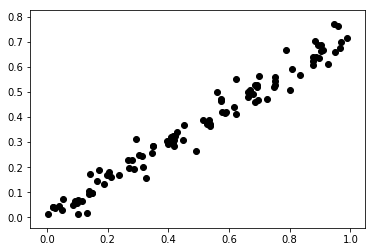

w_1 = [ 0.72032449]
b = [ 0.00011437]
noise (variance) = [[ 0.0417022]]


In [8]:
# plot the data and the gereating values behind it
plt.scatter(X,y,color = 'k')
plt.show()
print("w_1 = " + str(w[0]))
print("b = " + str(w[1]))
print("noise (variance) = " + str(sigma_v_sq))

**1.2 - Linear Regresion**

Time to learn.
In order to perform linear regression, we:
- Define our loss function as mean squared errors
- Perform Linear Regresion on the generated data
- Plot the fit in data space
- Plot the loss function in parameter space

In [9]:
# mean squared error for our linear model
def my_mse(y_hat,y):
    m = y_hat.shape[0]
    mse = (1.0/m)*np.sum(np.power(y_hat-y,2))
    return mse    

In [10]:
# perform linear regression using mean squared error as loss function
# please, do go through the derivations in: http://www.deeplearningbook.org/contents/ml.html (Section 5.1.4)
def my_linear_regression(X_train,y_train):
    assert(X_train.shape[0] == y_train.shape[0])
    # separate the derivation into chunks for easier understanding
    A = np.linalg.inv(np.dot(X_train.T,X_train))
    B = np.dot(A,X_train.T)
    w_pred = np.dot(B,y_train)
    return w_pred

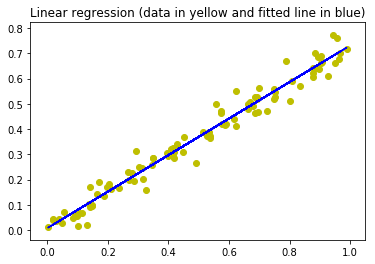

Predicted w = [[ 0.7232704 ]
 [ 0.00766488]]
Real w = [[  7.20324493e-01]
 [  1.14374817e-04]]
Mean squared error = 0.00136890403604


In [11]:
# call linear regression on our training data and get the real and predicted values for w and b, plotting the fit
# plot the fitted model in data space
w_pred = my_linear_regression(X_b,y)
y_pred = my_linear_model(X_b,w_pred)
mse = my_mse(y_pred,y)
# plot data and fit
plt.plot(X,y_pred, color = 'b')
plt.scatter(X, y, color = 'y')
plt.title('Linear regression (data in yellow and fitted line in blue)')
plt.show()
# print information
print("Predicted w = " + str(w_pred))
print("Real w = " + str(w))
print("Mean squared error = " + str(mse))



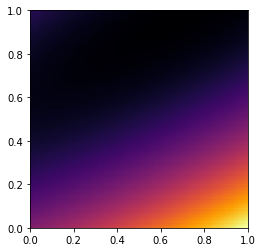

In [12]:
# plot the loss function (mean squared error) in parameter (w) space
# get the mean squared errors for a range of w and b values and plot the error heatmap
n_iter = 100
w_curr = np.zeros((2,1))
mse_errors = np.zeros((n_iter,n_iter))
min_mse = np.Inf
for i in range(n_iter):
    w_curr[0,0] = 1.0*i/n_iter
    for j in range(n_iter):
        w_curr[1,0] = 1.0*j/n_iter
        y_hat = my_linear_model(X_b,w_curr)
        mse_errors[i,j] = my_mse(y_hat,y)
plot_heatmap(mse_errors.T,'inferno')

Note that we were able to estimate quite closely the global minimum, but we don't have error bars nor any sort of probability distribution over the parameters
Try removing the noise form the linear model to see what happens

**1.2 Bayesian linear regression**

In [13]:
%%latex
The likelihood of the parameters given a data point is given by:
$$ P(\mathbf{y}_i|\mathbf{X}_i,\mathbf{w},\sigma_v) =  N(\mathbf{X}_i \mathbf{w},\sigma_v^2) $$
We informally define our data as the pair with $N$ points:
$$ D = (\mathbf{X},\mathbf{y}_i) $$
Then the likelihood given our entire training set is:
$$ P(D|\mathbf{w},\sigma_v^2) = \prod_{i=1}^{N} N(X_i \mathbf{w},\sigma_v^2) = \frac{exp[-\beta E_D(\mathbf{y}|\mathbf{w})]}{Z_D} $$ 
$$ Z_D = \Big(\frac{2\pi}{\beta}\Big)^\frac{N}{2} $$
$$ \beta = \frac{1}{\sigma_v^2} $$
$$ E_D = \sum_{i}^N (\mathbf{X}_i\mathbf{w}-\mathbf{y}_i)^2  $$
$E_D$ is the squared difference between the model with ($\mathbf{y}_i$) and without ($\mathbf{X}_i\mathbf{w}$) noise
$$$$
$P(D|\mathbf{w},\sigma_v)$ is the likelihood of the parameters given the data

<IPython.core.display.Latex object>

In [14]:
def likelihood_linear_model(X, y, w, noise_sigma):   
    beta = noise_sigma
    Z_D = np.power((2.0*np.pi/beta),n_pts/2)
    E_D = (1.0/2)*np.sum(np.power((y - np.dot(X,w)),2))
    P = np.exp(-beta*E_D)
    return P[0,0]

In [15]:
def get_bivariate_Gaussian_to_plot(mean_likelihood, var_likelihood):
    std_mult = 3
    # for some odd python reason, sigmax and sigma y are santard deviations, but sigmaxy is variance
    sigmax = np.sqrt(var_likelihood[0,0])
    sigmay = np.sqrt(var_likelihood[1,1])    
    sigmaxy = var_likelihood[0,1]
    max_sigma = max(sigmax,sigmay)
    delta = max_sigma/100
    beg_x = mean_likelihood[0,0]-std_mult*max_sigma
    end_x = mean_likelihood[0,0]+std_mult*max_sigma
    beg_y = mean_likelihood[1,0]-std_mult*max_sigma
    end_y = mean_likelihood[1,0]+std_mult*max_sigma
    x = np.arange(beg_x, end_x, delta)
    y = np.arange(beg_y, end_y, delta)
    X, Y = np.meshgrid(x, y)
    # ensure Z is ok (a classic probme is getting NaN because the variance is not positive semidefinite)
    Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean_likelihood[0], mean_likelihood[1], sigmaxy)
    assert(not np.any(np.isnan(Z)))
    return X, Y, Z

In [104]:
# Calculate the mean, covariance matrix and maximum value for the likelihood (print the information)

# get the A matrix, used in mean and covariance calculation
A = np.linalg.inv(np.dot(X_b.T,X_b))
# get the mean as a (2,1) array
mean_likelihood = np.dot(np.dot(A,X_b.T),y)
# get the covariance as a (2,2) array
covar_likelihood = sigma_v_sq*A
# get the estimated maximum value for the likelihood)
max_likelihood = likelihood_linear_model(X_b, y, mean_likelihood, sigma_v_sq)
# print information
print('Mean of likelihood = ' + str(mean_likelihood))
print('Covariance matrix of likelihood = ' + str(covar_likelihood))
print('Max likelihood = ' + str(max_likelihood))

Mean of likelihood = [[ 0.7232704 ]
 [ 0.00766488]]
Covariance matrix of likelihood = [[ 0.00487458 -0.00239781]
 [-0.00239781  0.0015965 ]]
Max likelihood = 0.997149754159


In [114]:
# Animate the likelihood using different random noise values for the linear model
# Resources:
#    https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# number of frames
n_frames = 50
# get the A matrix from the covariance matrix calculation in order to multiply by noise and get final covariance
A = np.linalg.inv(np.dot(X_b.T,X_b))
# get the maximum limits to fix them according to the maximum noise value (1.0)
fig, axes_likel, axes_likel_lims = plot_bivariate_gaussian(mean_likelihood, A, 3, 'k', False)

# define the animation function
def animate_likelihood(i):
    # clean plot at every frame
    axes_likel.cla()
    # get random noise
    sigmav_sq_curr = np.random.rand()
    # get the axes for the current bivariate Gaussian
    _, ax, _ = plot_bivariate_gaussian(mean_likelihood, sigmav_sq_curr*A, 3, 'k', False, axes_likel_lims)
    # calculate current estimated maximum likelihood
    max_likelihood_curr = likelihood_linear_model(X_b, y, mean_likelihood, sigmav_sq_curr*A)
    # add legend with current noise value
    noise_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    noise_text.set_text('Noise variance          = ' + str(sigmav_sq_curr))
    max_likel_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
    max_likel_text.set_text('Maximum likelihood = ' + str(max_likelihood_curr))
    # return axes and the legend
    return ax, noise_text

# call the animator, defining frame time interval and whether to repeat animation after it is done
anim = animation.FuncAnimation(fig, animate_likelihood, frames=n_frames, interval=500, repeat = False)
# convert to video in order to show in Jupyter notebook
HTML(anim.to_html5_video())

[1] MacKay, David JC. Information theory, inference and learning algorithms. Cambridge university press, 2003.

[2] MacKay, David JC. "Bayesian interpolation." Neural computation 4.3 (1992): 415-447.